# Basic Multi-agent Collaboration

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like gpt-4, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".

This notebook (inspired by the paper AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation, by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

https://arxiv.org/abs/2308.08155

![](./images/Collaboration.png)


Before we get started, a quick note: this and other multi-agent notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.



In [6]:
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core
%pip install python-dotenv


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
from dotenv import load_dotenv
import os

load_dotenv(override=True)


True

# Create Agents
The following helper functions will help create agents. These agents will then be nodes in the graph.

You can skip ahead if you just want to see what the graph looks like.


In [17]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)


# Define tools
We will also define some tools that our agents will use in the future



In [18]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


# Create graph
Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

## Define State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender



In [20]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


## Define Agent Nodes
We now need to define the nodes. First, let's define the nodes for the agents.


In [21]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4-1106-preview")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")


## Define Tool Node
We now define a node to run the tools



In [22]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)


##  Define Edge Logic
We can define some of the edge logic that is needed to decide what to do based on results of the agents



In [23]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"


## Define the Graph
We can now put it all together and define the graph!



In [25]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()



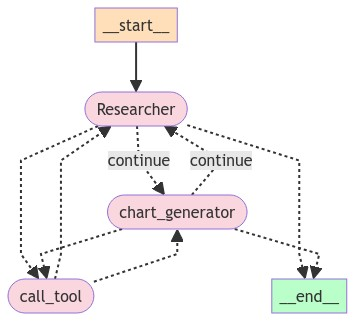

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HgjLncbPsCEsmCzYodFQVHi8', 'function': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 221, 'total_tokens': 246}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-a7cf2950-7c03-42f4-a26b-4614af1555c1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP over the past 5 years'}, 'id': 'call_HgjLncbPsCEsmCzYodFQVHi8'}], usage_metadata={'input_tokens': 221, 'output_tokens': 25, 'total_tokens': 246})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ihyp/pn2", "content": "Preliminary estimate of GDP time series (PGDP), releas

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1mhOtRVET35In3ddw8pYtW8s', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# GDP values in billions of dollars\\nyears = [2019, 2020, 2021]\\ngdp_values = [2851.41, 2697.81, 3141.51]\\n\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp_values, marker=\'o\')\\n\\nplt.title(\'UK GDP Over the Past 3 Years (2019-2021)\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP in Billions of USD\')\\nplt.grid(True)\\nplt.xticks(years)\\nplt.tight_layout()\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 7151, 'total_tokens': 7305}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, name='chart_generator', id='run-73e6dd61-0247-4fb0-bba1-39dc961549a1-0', tool_calls=[{'name': 'python_repl', 'args': {'code': "import matplotlib

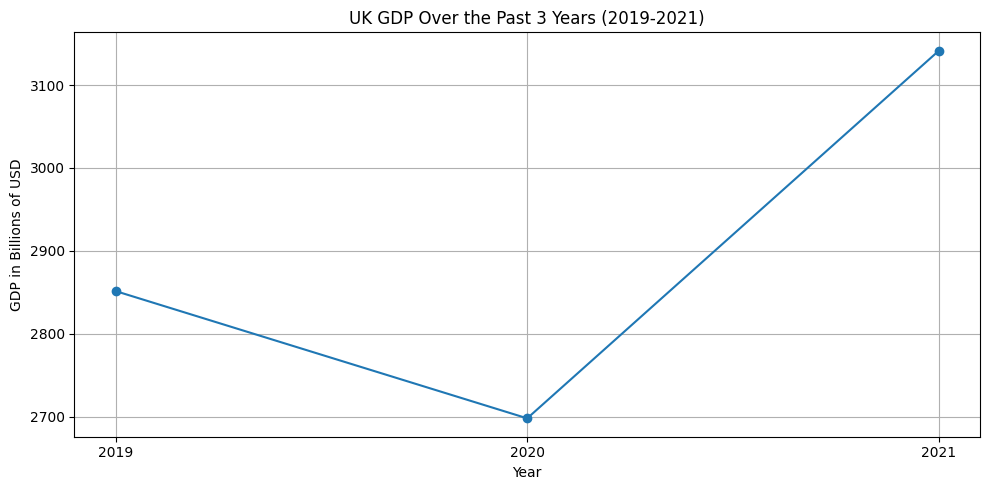

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# GDP values in billions of dollars\nyears = [2019, 2020, 2021]\ngdp_values = [2851.41, 2697.81, 3141.51]\n\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_values, marker='o')\n\nplt.title('UK GDP Over the Past 3 Years (2019-2021)')\nplt.xlabel('Year')\nplt.ylabel('GDP in Billions of USD')\nplt.grid(True)\nplt.xticks(years)\nplt.tight_layout()\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_1mhOtRVET35In3ddw8pYtW8s')]}}
----
{'chart_generator': {'messages': [AIMessage(content='FINAL ANSWER\n\nHere is the line graph representing the UK GDP over the past 3 years (2019-2021):\n\n![UK GDP 2019-2021](sandbox:/code/execution_images/6e9fbb56-0e8d-4f5d-9f78-2fc7e3d8e10e.png)\n\nPlease note that the data for 2022 and 2023 is not included as it was not available in the search results.', response

In [27]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")
